# University of Liverpool

## ENVS615:  Analysis of Human Dynamics
### ***Student ID:  201266656***

 <div class="alert alert-block alert-info">The following code, comments and annotation text detail the analysis process which resulted in the narrative interpretation given below.  In any analysis, there are some branches of thought which do not prove fruitful, there are some explorations which do not reveal insight and there are some preliminary steps which are not particularly interesting but which guide the way.  Where possible, inclusion of simple steps such as these has been omitted to provide clarity.  Where techniques are used repeatedly, the commenting of code is reduced in length and complexity after the first instance.</div>


# 1.0  Introduction

For most of us, a property is the most expensive purchase of our lifetime.  In the UK, we have a longstanding culture of home ownership and have over time, seen significant appreciation of residential assets - the so called housing 'boom'(English Housing Survey 2017; Ortalo-Magne and Rady 1999).  Significant government policy effort is directed into home ownership with schemes such as Right-to-Buy, Help to Buy and shared owneship all occupying headlines in recent decades (Money Advice Service 2018).

Our home is where we gather with friends and family, where we provide stability for our children, and where we conduct much of our lived experience.  It can also be our place of work or our business premises.

Considering this context, how much should we pay for a house, and what factors can we build into a model which might allow us to predict house prices at a hyper-local level?

Frischtak and Mandel write that when crime rates reduce in a Brazillian favela by the introduction of a police station, the surrounding areas undergo an increase in property values (Frischtak and Mandel 2012).  Gibbons and Machin link improved transport and lower crime to higher house prices in the UK (Gibbons and Machin 2008).

Gambling machine density is highest in areas of high Socio-Economic Deprivation, where houses are cheapest (Wardle et al. 2014) and it is hypothesised that this relationship would also extend to fastfood outlets.

Poor air quality has been linked to reduced house prices (Anderson and Crocker 2016) and increasing greenspace in urban contexts is proposed as a means to elevate depressed inner city housing markets (Conway et al 2010).

This paper seeks to build a model using these factors to predict house prices and to classify areas at the lower super output layer level (LSOA) within Greater Manchester.

# 2.0 Variables and Data

Data were imported, cleaned and processed into correct types (floats) and renamed for simplicity and homogeneity.  The PT variable was calculated from the imported transport data.  A four way merge produced a master dataset useable for analysis.

The variables in the final master dataset are as follows:

* **Year to end Jun 2017** Median price of a house sold in the LSOA, 
*  **log_price**  the natural log of the median price
* **gamble** Mean distance in km to a gambling outlet - a measure of the density of betting shops
* **fastfood** Mean distance in km to a fast food outlet - a measure of the density of fast food outlets
* **no2** Annual mean (µgm3) nitrogen dioxide
* **particulates** Annual mean (µgm3) particulate matter
* **greenspace** Square metres of green space
* **PT** Categorical variable representing access to public transport with values ‘poor’ ‘moderate’ and ‘good’ based on the number of users within an LSOA who can get to an employment centre within a ‘reasonable’ time.
* **Geometry** `geopandas` readable geometry field with polygon geometry for plotting (present for LSOA and LA in separate files)
* **Local authority name** Names of local authorities (‘LA’) in Greater Manchester
* **LSOA code** Unique identified for each Lower layer super output area (‘LSOA’)

In [532]:
%matplotlib inline
#  Use matplotlib magic to ensure that plots render inline and are saved as part of this notebook

#  Import packages, and assign alias
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

import statsmodels.formula.api as sm

from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn import metrics, cluster
from sklearn import preprocessing
from sklearn.decomposition import PCA

#  Set seaborn defaults for plots
sns.set_style("white")

## 2.1 House price data

House price data at the LSOA level were taken from the Office of National Statistics. The figures provided are a median of the prior 12 months, taken quarterly. The latest figures available at this level are for June 2017 (ONS 2018).

A pragmatic approach to imputation was taken using a localised mean for each missing value and the last known value for June 2017. For example, if December is missing, the mean of September and March is imputed. Missing data for Sept 2016 were not imputed.  Post imputation, rows with missing June values are excluded.

House prices are geographically sensitive and subject to spatial autocorrelation (Tse 2016).  Any model seeking to predict a median house price must therefore control for location and account for the dependency of house price, on prices in the vicinity.  For this exploratory analysis, The data were sampled to include only LSOAs within the Greater Manchester city region which consists of ten local authorities (Bolton. Bury, Manchester, Oldham, Rochdale, Salford, Stockport, Tameside, Trafford, Wigan) (Manchester City Council 2018).  This reduces the impact of geography on the dependent variable and the complexity of the model.

House price data are available at the lower super output area level from the Office of National Statistics.  The figures provided are a median of the prior 12 months, taken quarterly.  The latest figures available through ONS at this level are for June 2017, these have been manually downloaded as a `.csv` file to be imported for analysis using the Python package `pandas`.

Using a list object `var` for the variables needed allows easier selection of the relevant data into a dataframe for analysis, the list `qtrs` is used to define variables that should be subject to certain processing routines.  `GM` contains the local authority names of all the local authorities which make up the Greater Manchester area. 

In [2]:
#  Create lists
var = ['LSOA name','LSOA code', 'Local authority code',\
       'Local authority name','Year ending Sep 2016',\
       'Year ending Dec 2016','Year ending Mar 2017',\
       'Year ending Jun 2017']

qtrs = ['Year ending Sep 2016',\
       'Year ending Dec 2016','Year ending Mar 2017',\
       'Year ending Jun 2017']

GM = ['Salford','Oldham','Manchester','Wigan','Bolton','Tameside','Trafford','Stockport','Bury','Rochdale']

In [3]:
#  Read in historic house prices data.  Manually downloaded as a .csv
hp = pd.read_csv('house_prices.csv', low_memory = False)[var]

#  Eyeball check of data
hp.head()

,LSOA name,LSOA code,Local authority code,Local authority name,Year ending Sep 2016,Year ending Dec 2016,Year ending Mar 2017,Year ending Jun 2017
0,Hartlepool 008A,E01011950,E06000001,Hartlepool,"26,750","30,000","33,500","35,000"
1,Hartlepool 009A,E01011949,E06000001,Hartlepool,"78,000","90,000","78,000","99,950"
2,Hartlepool 007A,E01011951,E06000001,Hartlepool,"50,000","62,500","65,000","55,500"
3,Hartlepool 002B,E01011953,E06000001,Hartlepool,"65,000","83,250","100,000","55,000"
4,Hartlepool 001A,E01011954,E06000001,Hartlepool,"87,000","85,000","88,500","98,450"


In [4]:
#  View variable types and an overview of the DataFrame size
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34856 entries, 0 to 34855
Data columns (total 8 columns):
LSOA name               34753 non-null object
LSOA code               34753 non-null object
Local authority code    34674 non-null object
Local authority name    34753 non-null object
Year ending Sep 2016    34753 non-null object
Year ending Dec 2016    34753 non-null object
Year ending Mar 2017    34753 non-null object
Year ending Jun 2017    34753 non-null object
dtypes: object(8)
memory usage: 2.1+ MB


###  2.1.1 Cleaning the data:  UK house prices

*  Code missing values to `NaN` using `numpy`
*  Assess data types within the DataFrame
*  Convert prices to `string`
*  Remove comma
*  Convert prices to `float` 
*  Use lambda function and loope to apply to multiple columns


`lambda` functions are a method of defining an anonymous function, unlike the `def` command where the function is assigned to an object.  For the simple routines used here, this is more memory and code efficient.  A `lambda` function is used here to remove the comma, this is placed within a loop so that each column of price data is processed identically. 

The warning message refers to the copying of processed data over the original values of the dataset.  This is acceptable here as a previous version of the un-processed data has been retained.  Caution must be exercised when overwriting values in a dataset, particularly if this is deep into processing as an error may cause the loss of important data. This is inconvenient and time consuming if it is noticed and the processing re-run but could seriously jeopardise the validity of any analysis if undetected.


In [5]:
%%time
#  time magic to record the time taken to execute this cell

# Convert price data into string
# Define lambda function to remove comma
# Convert string to float
# Recode ':' to NaN
# Set up a loop to apply above to all four price columns  
for i in qtrs:
    hp[i] = hp[i].astype(str).apply(lambda x: (x.replace(',','')))
    hp[i].loc[hp[i]==':']=np.NaN
    hp[i]=hp[i].astype(float)


CPU times: user 324 ms, sys: 20.8 ms, total: 344 ms
Wall time: 348 ms


/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
hp.head()

,LSOA name,LSOA code,Local authority code,Local authority name,Year ending Sep 2016,Year ending Dec 2016,Year ending Mar 2017,Year ending Jun 2017
0,Hartlepool 008A,E01011950,E06000001,Hartlepool,26750.0,30000.0,33500.0,35000.0
1,Hartlepool 009A,E01011949,E06000001,Hartlepool,78000.0,90000.0,78000.0,99950.0
2,Hartlepool 007A,E01011951,E06000001,Hartlepool,50000.0,62500.0,65000.0,55500.0
3,Hartlepool 002B,E01011953,E06000001,Hartlepool,65000.0,83250.0,100000.0,55000.0
4,Hartlepool 001A,E01011954,E06000001,Hartlepool,87000.0,85000.0,88500.0,98450.0


In [7]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34856 entries, 0 to 34855
Data columns (total 8 columns):
LSOA name               34753 non-null object
LSOA code               34753 non-null object
Local authority code    34674 non-null object
Local authority name    34753 non-null object
Year ending Sep 2016    34294 non-null float64
Year ending Dec 2016    34196 non-null float64
Year ending Mar 2017    34047 non-null float64
Year ending Jun 2017    34096 non-null float64
dtypes: float64(4), object(4)
memory usage: 2.1+ MB


### 2.1.2 House price missing data

* Assess how many values are missing and where the missing data occur
* Impute values of missing data - localised mean, last known value
* Reassess extent of missing data using 
* Drop rows as required 

In [8]:
len(hp)

34856

In [9]:
#  Number of rows containing a missing value
len(hp[hp.isnull().any(axis=1)])

1259

In [10]:
#  Number of rows where June 2017 is a missing value
len(hp[hp['Year ending Jun 2017'].isnull()])

760

In [11]:
#  Number of rows containg all missing values
len(hp[hp.isnull().all(axis=1)])

103

In [12]:
#  Drop 103 rows where all data is missing, these rows are empty rows at the bottom of the dataframe
#  Leaves a dataframe of 34753 rows
hp = hp.dropna(how='all')

# Impute a localised mean for Dec 2016 and Mar 2017.  Use last known value for June 2017
# inplace = True means values are retained within the DataFrame
hp['Year ending Dec 2016'].fillna(hp[['Year ending Sep 2016','Year ending Mar 2017']].mean(axis = 1),\
                                  inplace = True) 
hp['Year ending Mar 2017'].fillna(hp[['Year ending Dec 2016','Year ending Jun 2017']].mean(axis = 1),\
                                  inplace = True) 
hp['Year ending Jun 2017'].fillna(hp['Year ending Mar 2017'],\
                                  inplace = True)      

#  Recheck missing data counts
hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34753 entries, 0 to 34752
Data columns (total 8 columns):
LSOA name               34753 non-null object
LSOA code               34753 non-null object
Local authority code    34674 non-null object
Local authority name    34753 non-null object
Year ending Sep 2016    34294 non-null float64
Year ending Dec 2016    34472 non-null float64
Year ending Mar 2017    34530 non-null float64
Year ending Jun 2017    34530 non-null float64
dtypes: float64(4), object(4)
memory usage: 2.4+ MB


In [13]:
#  Number of rows where June 2017 is a missing value
h = hp.dropna(subset=['Year ending Jun 2017']) 

#  Number of rows where June 2017 is a missing value - confirm now zero
len(h[h['Year ending Jun 2017'].isnull()])

0

###  2.1.3 Selecting a sample

*  Use list `GM` to select LSOAs of interest

In [14]:
#  Selecting Greater Manchester authorities only for a reduced dataset
gmh = h.loc[h['Local authority name'].isin(GM)]

#  Checking the data
gmh.head()

,LSOA name,LSOA code,Local authority code,Local authority name,Year ending Sep 2016,Year ending Dec 2016,Year ending Mar 2017,Year ending Jun 2017
20786,Bolton 003C,E01004771,E08000001,Bolton,185000.0,170500.0,171000.0,167500.0
20787,Bolton 003B,E01004770,E08000001,Bolton,150000.0,137475.0,152000.0,152000.0
20788,Bolton 005B,E01004767,E08000001,Bolton,89000.0,96000.0,84000.0,85000.0
20789,Bolton 003A,E01004769,E08000001,Bolton,139950.0,145500.0,156500.0,157000.0
20790,Bolton 005C,E01004772,E08000001,Bolton,81000.0,81000.0,92000.0,152500.0


In [15]:
gmh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657 entries, 20786 to 22458
Data columns (total 8 columns):
LSOA name               1657 non-null object
LSOA code               1657 non-null object
Local authority code    1657 non-null object
Local authority name    1657 non-null object
Year ending Sep 2016    1635 non-null float64
Year ending Dec 2016    1652 non-null float64
Year ending Mar 2017    1657 non-null float64
Year ending Jun 2017    1657 non-null float64
dtypes: float64(4), object(4)
memory usage: 116.5+ KB


## 2.2  Geometries and crime decile
The `geopandas` package is a specifically adapted version of `pandas` designed to cope with geospatial data. Local authority boundary data was taken from the [UK government geostatistics portal](http://geoportal.statistics.gov.uk/datasets/census-merged-local-authority-districts-december-2011-generalised-clipped-boundaries-in-great-britain) (UK Government 2011).  LSOA boundaries and crime deciles were taken from the [English Indices of Deprivation dataset](https://data.cdrc.ac.uk/dataset/cdrc-2015-english-indices-of-deprivation-geodata-pack-greater-manchester-e37000015/) (CDRC 2015).


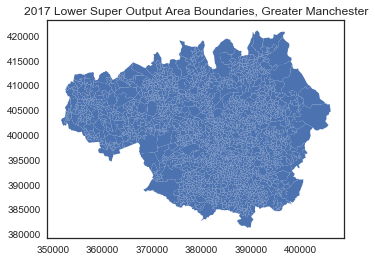

In [328]:
#  Read in geographical data file - LSOA
lsoa = gpd.read_file('shape/E37000015_domain.shp')

#  Rename LSOA code column to homogenise between datasets.  
lsoa.rename(columns={'lsoa11cd': 'LSOA code'}, inplace = True)

#  View the geographical file as a plot
lsoa.plot();
plt.title('2017 Lower Super Output Area Boundaries, Greater Manchester');
plt.show()

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


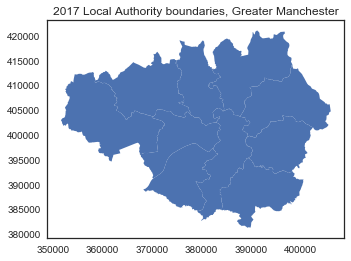

In [329]:
#  Reading in England and Wales local authority shapefile, reducing to Greater Manchester only
LA = gpd.read_file\
('LA/Census_Merged_Local_Authority_Districts_December_2011_Generalised_Clipped_Boundaries_in_Great_Britain.shp')
GM_LA = LA.loc[LA['cmlad11nm'].isin(GM)]

#  Rename Local Authority Name column to homogenise between datasets
GM_LA.rename(columns ={'cmlad11nm':'Local authority name'}, inplace = True)

#  Plot the boundaries
GM_LA.plot();
plt.title("2017 Local Authority boundaries, Greater Manchester")
plt.show()

## 2.3 Access fo Health Assets and Hazards

Other variables were taken from the [Access to Healthy Assets and Hazards](https://data.cdrc.ac.uk/dataset/cdrc-2015-english-indices-of-deprivation-geodata-pack-greater-manchester-e37000015/) index input files (CDRC 2017).

The fields selected for analysis are as follows:

* **gamb_d**	   Mean distance in km to a gambling outlet - a measure of the density of betting shops
* **ffood_d**	   Mean distance in km to a fast food outlet - a measure of the density of fast food outlets
* **NO2**	       Annual mean (µgm3)	nitrogen dioxide
* **PM2**        Annual mean (µgm3)  particulate matter
* **green900**   Square metres of green space

The columns are renamed for ease of reference, calling `.info()` shows that there are no missing data and the variables of interest are in numeric formats so no further processing is required.

In [200]:
#  Read in Access to Healthy Assets and Hazards input data file, and select variables of interest.
ahahinputs_var = ['lsoa11','gamb_d','ffood_d','pm10','no2','green900']
AHAH_input = pd.read_csv('ahahinputs.csv', low_memory = False)[ahahinputs_var]

# Rename column headers for ease of reference
AHAH_input.rename(columns ={'lsoa11':'LSOA code',\
                            'gamb_d':'gamble',\
                            'ffood_d':'fastfood',\
                            'pm10':'particulates',\
                            'green900':'greenspace'}, inplace = True)
# Check data
AHAH_input.head()

,LSOA code,gamble,fastfood,particulates,no2,greenspace
0,W01000934,0.848966,0.272759,11.697524,8.578175,0.524383
1,E01015190,3.291429,1.792381,11.757697,5.705482,0.171663
2,E01007121,0.661818,1.327273,11.197694,11.223578,1.303351
3,W01001937,9.938169,9.715775,9.199155,4.088596,0.278397
4,W01000740,1.085357,3.114286,11.264084,7.950189,0.064115


In [201]:
#  Call .info() to show data types and extent of missing data
AHAH_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41729 entries, 0 to 41728
Data columns (total 6 columns):
LSOA code       41729 non-null object
gamble          41729 non-null float64
fastfood        41729 non-null float64
particulates    41729 non-null float64
no2             41729 non-null float64
greenspace      41729 non-null float64
dtypes: float64(5), object(1)
memory usage: 1.9+ MB


## 2.4  Availability of public transport

Greater Manchester is an urban area and the third largest city in the UK.  There is significant business and enterprise within the city region and a large number of employment centres.

The availability of public transport was categorised using data from the Department for Transport.  In this analysis, LSOAs are categorised as Good, Moderate or Poor in relation to their public transport, based on the proportion of users within an LSOA who can get to an employment centre by public transport within a reasonable time.   

For missing data, the value ‘moderate’ was imputed.  Greater Manchester, like many cities, has a congestion problem. The tram serves many parts of the city but there are exceptions, and it can be very difficult for people in these areas to get to work. This variable seeks to capture this feature of an LSOA as it could be important when determining the price a buyer is prepared to pay for a house. The variable includes walking within "Public Transport" so an LSOA which has an employment centre within it, and no public transport links at all, would still score highly here [(Department for Transport 2007)](https://www.gov.uk/government/statistical-data-sets/acs05-travel-time-destination-and-origin-indicators-to-key-sites-and-services-by-lower-super-output-area-lsoa#table-acs0501).

The underlying excel file is large (227MB) and contains multiple tabs of historic data.  To save memory the relevant tab was exported to a `.csv` file from within MSExcel, suitable variables were identified from the online metadata, and a list used to select and read in only those variables of interest.  Prior to categorisation, the variable required processing into a numeric format.

* Read in transport data
* Clean numerical variables (convert to string, remove comma, convert to float)
* Create categorical variable based on a function of two variables

In [330]:
#  Define variables required
t = ['EMPLO001','EMPLO004','EMPLO006','EMPLO059']

#  Read in file
transport = pd.read_csv('acs0501_2013.csv', \
                        low_memory = False)[t].rename\
                        (columns={'EMPLO001':'LSOA code',\
                                  'EMPLO004':'Local authority name',\
                                  'EMPLO006':'Users',\
                                  'EMPLO059':'emp_reasonable'})
#  Select GM LAs only
transport = transport.loc[transport['Local authority name'].isin(GM)]

#  Check type of data
transport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 4765 to 6410
Data columns (total 4 columns):
LSOA code               1646 non-null object
Local authority name    1646 non-null object
Users                   1646 non-null object
emp_reasonable          1646 non-null object
dtypes: object(4)
memory usage: 64.3+ KB


In [331]:
#  Define list of variables to be processed
u = ['Users','emp_reasonable']

# To change the users data into numeric form, define a lambda function to remove the comma and transform to float
# Set up a loop to apply above to two columns  
for i in u:
    transport[i] = transport[i].astype(str).apply(lambda x: (x.replace(',','')))
    transport[i]=transport[i].astype(float)

# call .info() to check data type is now float    
transport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 4765 to 6410
Data columns (total 4 columns):
LSOA code               1646 non-null object
Local authority name    1646 non-null object
Users                   1646 non-null float64
emp_reasonable          1646 non-null float64
dtypes: float64(2), object(2)
memory usage: 64.3+ KB


In [332]:
#  set up y as the proportion of users in an LSOA
y = (transport['emp_reasonable'])/(transport['Users'])

#  Define a function to categorise the result of y
def func(x):
    if x < 0.75:
        return 'Poor'
    elif 0.75 <= x < 0.85:
        return 'Moderate'
    elif 0.85 <= x:
        return "Good"

#  Use .apply() to categorise the results of y and set up a new variable 'PT' (Public Transport)
transport['PT'] = y.apply(func)

#  Check the data
transport.head()

,LSOA code,Local authority name,Users,emp_reasonable,PT
4765,E01004766,Bolton,1160.0,1036.0,Good
4766,E01004767,Bolton,1280.0,1149.0,Good
4767,E01004768,Bolton,1170.0,922.0,Moderate
4768,E01004769,Bolton,1130.0,902.0,Moderate
4769,E01004770,Bolton,1010.0,824.0,Moderate


##  2.5 Joining the data

*  Merge 4 datasets to produce a master dataset using lists of variables
*  Use both right and left joins to exclude LSOAs not within Greater Manchester
*  Set dataframe index
*  Impute missing data

Using a combination of left and right joins and the merge function, the four datasets can be combined to produce a super dataset containing all variables of interest.  Introducing the measure of public transport increases the extent of missing data.  Missing fields are imputed with the value 'Moderate'.

The index of the dataset is set using `.set_index` to the LSOA code.

In [224]:
lsoa_v = ['LSOA code','crime_d','geometry']
gmh_v = ['LSOA code','Local authority name','Year ending Jun 2017']
transport_v = ['LSOA code','PT']

#  Create new dataset by merging LSOA, gmh, ahah and transport data
#  Use lists to define the variables of interest for merge
#  Use right join to retain only geometries for LSOAs where there are house price data within the dataset.
#  Retain only LSOA code, geometries and crime decile from lsoa
#  Use right join to allow first merge to act as a cookie cutter on AHAH data.
data = lsoa[lsoa_v].merge(gmh[gmh_v],\
                        on = 'LSOA code',\
                        how = 'right')\
                   .merge(AHAH_input,\
                        on='LSOA code',\
                        how = 'left')\
                   .merge(transport[transport_v],\
                        on='LSOA code',\
                        how = 'left').set_index('LSOA code')

#  Check the data
data.head()

,crime_d,geometry,Local authority name,Year ending Jun 2017,gamble,fastfood,particulates,no2,greenspace,PT
LSOA code,,,,,,,,,,
E01004766,2.0,"POLYGON ((370972.988 411319.416, 370972.906 41...",Bolton,85250.0,0.557143,0.364694,11.782014,12.953131,0.208212,Good
E01004767,2.0,"POLYGON ((371505 411499, 371505 411502.318, 37...",Bolton,85000.0,0.673913,0.402826,11.728405,12.884251,0.097754,Good
E01004768,7.0,"POLYGON ((371146.001 413306, 371154.995 413297...",Bolton,239000.0,1.336667,1.622857,11.291702,11.271938,0.324801,Moderate
E01004769,5.0,"POLYGON ((372060.628 413005.554, 372067.812 41...",Bolton,157000.0,0.644687,1.347500,11.421186,12.035371,0.174200,Moderate
E01004770,8.0,"POLYGON ((371999.668 412222.406, 371999.723 41...",Bolton,152000.0,1.243462,1.171538,11.518634,12.376332,0.054666,Moderate


In [225]:
#  Look at the data info to confirm no missing variables, and all variables in the correct dtype
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1657 entries, E01004766 to E01033688
Data columns (total 10 columns):
crime_d                 1657 non-null float64
geometry                1657 non-null object
Local authority name    1657 non-null object
Year ending Jun 2017    1657 non-null float64
gamble                  1657 non-null float64
fastfood                1657 non-null float64
particulates            1657 non-null float64
no2                     1657 non-null float64
greenspace              1657 non-null float64
PT                      1593 non-null object
dtypes: float64(7), object(3)
memory usage: 142.4+ KB


In [243]:
#  Fill missing values for PT with 'Moderate'
data['PT'].fillna('Moderate', inplace = True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1657 entries, E01004766 to E01033688
Data columns (total 10 columns):
crime_d                 1657 non-null float64
geometry                1657 non-null object
Local authority name    1657 non-null object
Year ending Jun 2017    1657 non-null float64
gamble                  1657 non-null float64
fastfood                1657 non-null float64
particulates            1657 non-null float64
no2                     1657 non-null float64
greenspace              1657 non-null float64
PT                      1657 non-null object
dtypes: float64(7), object(3)
memory usage: 222.4+ KB


## 2.6 Visualising the variables of interest

* Visualise variables to assess normality
* Heatmap of variables to show spatial nature of the data

Before conducting a regression analysis or performing a classificaiton, it is useful to explore variables via a series of visualisations.  For the continuous variables, a density plot is used.  For the crime decile variable, a histogram with 10 bins is the most appropriate plot and for the categorical variable 'PT' a bar plot of counts is presented. 

Initial visualisation of the price variable, shows it not to be normally distributed.  It is sensible in this instance to use the natural log of house price, rather than the house price itself for regression analysis.  A density plot of the log of house price is also given below.

The dataset also includes geometry and using `geopandas` we can plot each of the variables as a heat map of the Greater Manchester city region.

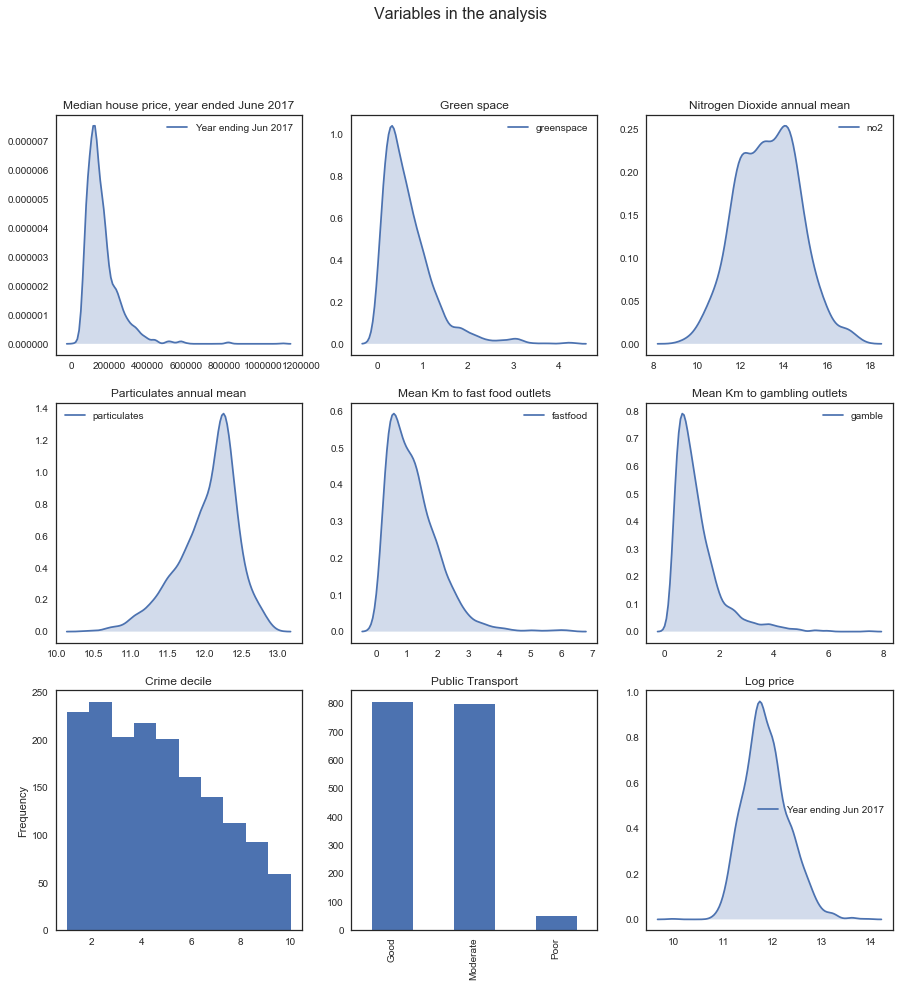

In [333]:
#  Use matplotlib to examine individual variables
f,ax = plt.subplots(3,3, figsize = (15,15));
ax = ax.flatten(); 

#  Plot density plots for continuous variables
sns.kdeplot(data['Year ending Jun 2017'], shade=True, ax=ax[0])
sns.kdeplot(data['greenspace'], shade=True, ax=ax[1])
sns.kdeplot(data['no2'], shade=True, ax=ax[2])
sns.kdeplot(data['particulates'], shade=True, ax=ax[3])
sns.kdeplot(data['fastfood'], shade=True, ax=ax[4])
sns.kdeplot(data['gamble'], shade=True, ax=ax[5])

#  Plot a histogram of crime decile (10 bins)
data['crime_d'].plot.hist(bins = 10, ax = ax[6]);

#  Plot a bar chart of counts for categorical data
data['PT'].value_counts().plot(kind='bar', ax = ax[7])

#  Plot the log of house price (dependent variable)
sns.kdeplot(np.log(data['Year ending Jun 2017']), shade=True, ax=ax[8]);

# Specify subplot titles
ax[0].title.set_text('Median house price, year ended June 2017');
ax[1].title.set_text('Green space');
ax[2].title.set_text('Nitrogen Dioxide annual mean');
ax[3].title.set_text('Particulates annual mean');
ax[4].title.set_text('Mean Km to fast food outlets');
ax[5].title.set_text('Mean Km to gambling outlets');
ax[6].title.set_text('Crime decile');
ax[7].title.set_text('Public Transport');
ax[8].title.set_text('Log price');

plt.suptitle('Variables in the analysis', fontsize = 16)
plt.show()

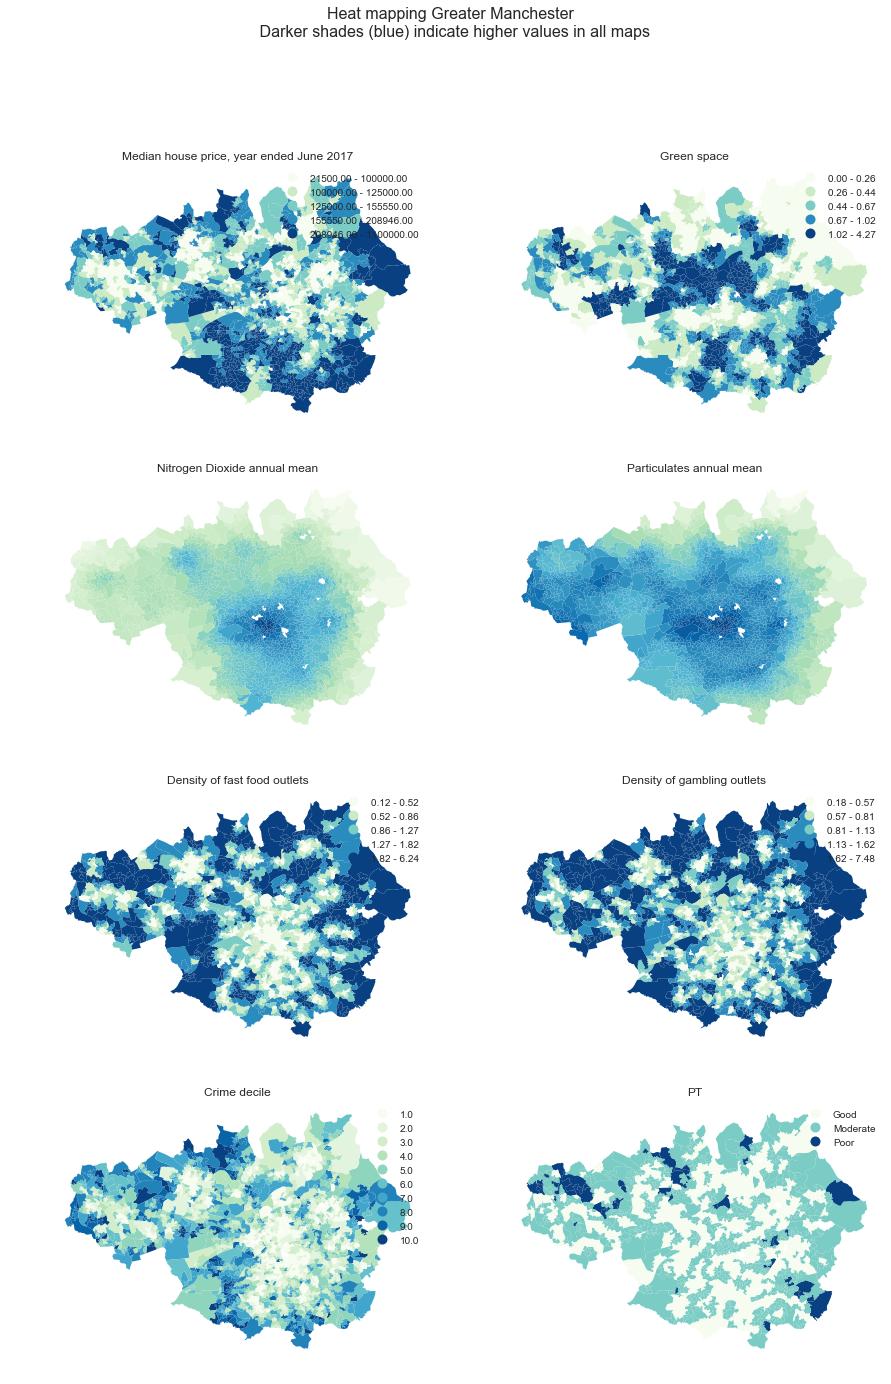

In [301]:
#  Use matplotlib to plot a series of heat maps
f, ax = plt.subplots(4,2, figsize=(15, 22));
ax = ax.flatten(); # this turns the 2D array into a list so you only need to specify one dimension

data.plot(column = 'Year ending Jun 2017',cmap = 'GnBu',scheme='quantiles',legend = True, ax=ax[0]);
data.plot(column = 'greenspace',cmap = 'GnBu',scheme='quantiles',legend = True,ax=ax[1]);                              
data.plot(column = 'no2',cmap = 'GnBu',ax=ax[2]);                               
data.plot(column = 'particulates',cmap = 'GnBu',ax=ax[3]);                                
data.plot(column = 'fastfood',cmap = 'GnBu',scheme='quantiles',legend = True,ax=ax[4]);  
data.plot(column = 'gamble',cmap = 'GnBu',scheme='quantiles',legend = True,ax=ax[5]);  
data.plot(column = 'crime_d',cmap = 'GnBu',categorical = True,legend = True,ax=ax[6]);  
data.plot(column = 'PT',cmap = 'GnBu',legend = True,categorical = True, ax=ax[7]);

# Specify subplot titles
ax[0].title.set_text('Median house price, year ended June 2017')
ax[1].title.set_text('Green space')
ax[2].title.set_text('Nitrogen Dioxide annual mean')
ax[3].title.set_text('Particulates annual mean')
ax[4].title.set_text('Density of fast food outlets')
ax[5].title.set_text('Density of gambling outlets')
ax[6].title.set_text('Crime decile')
ax[7].title.set_text('PT')

# Remove axes for easier viewing
for i in range(8):
    ax[i].set_axis_off();

# Set legend location
#for i in range(8):
 #   ax.legend(loc = 3)

plt.suptitle('Heat mapping Greater Manchester'\
             ' \n Darker shades (blue) indicate higher values in all maps', fontsize=16);

plt.figure();

## 2.7 Removing outliers

Within the dependent variable, there is a significant outlier.  If we remove the `scheme = 'quantiles'` argument from the choropeth mapping command, this can be seen on the spatial plot as a small area of dark blue in the south west, whilst the rest of the city region is pale green.  This area is a wealthy suburb of Manchester within the Trafford borough bordering the "footballer belt" of Cheshire.

Plotting the variable as a histogram with 100 bins shows the outlier more clearly as falling at around £1.1m.

The record for this LSOA can be pulled for inspection from the dataframe using `.loc()` and `.transpose()`.  The record can then be removed from the data using `.drop()`.

Plotting the choropeth maps with this outlier removed shows little discernible difference (by eye) on the chlorpeth map and only a small change in the mean house price, however the standard deviation changes by nearly 4% and so for this analysis, **LSOA E01006134** is excluded. 

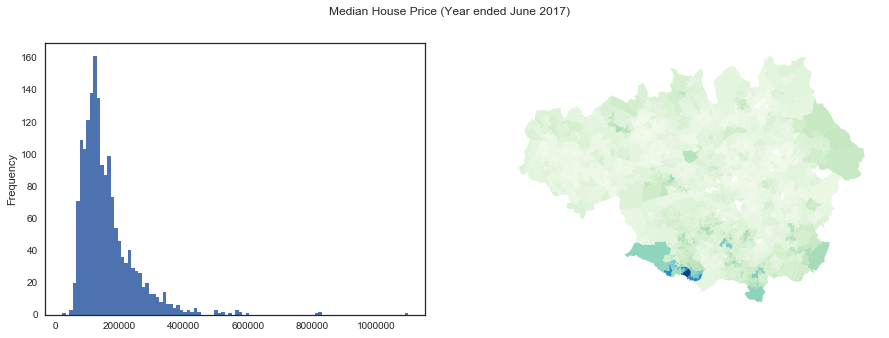

In [317]:
#  Plot a histogram of house price (100 bins)
f, ax = plt.subplots(1,2, figsize=(15, 5));
ax = ax.flatten();

data['Year ending Jun 2017'].plot.hist(bins = 100, ax = ax[0]);
data.plot(column = 'Year ending Jun 2017',cmap = 'GnBu',ax=ax[1]);

ax[1].set_axis_off();

plt.suptitle('Median House Price (Year ended June 2017)');
plt.show();

In [274]:
#  Find the outlier in house prices - around £1.1m according to histogram
#  Transpose the record for easier viewing
data.loc[data['Year ending Jun 2017']==data['Year ending Jun 2017'].max(), :].T

LSOA code,E01006134
crime_d,9
geometry,"POLYGON ((377743.721 385534.441, 377717 385553..."
Local authority name,Trafford
Year ending Jun 2017,1.1e+06
gamble,2.26343
fastfood,1.201
particulates,11.745
no2,12.3719
greenspace,0.83105
PT,Moderate


In [ ]:
#  Drop the row containing the outlier
df = data.drop(['E01006134'])

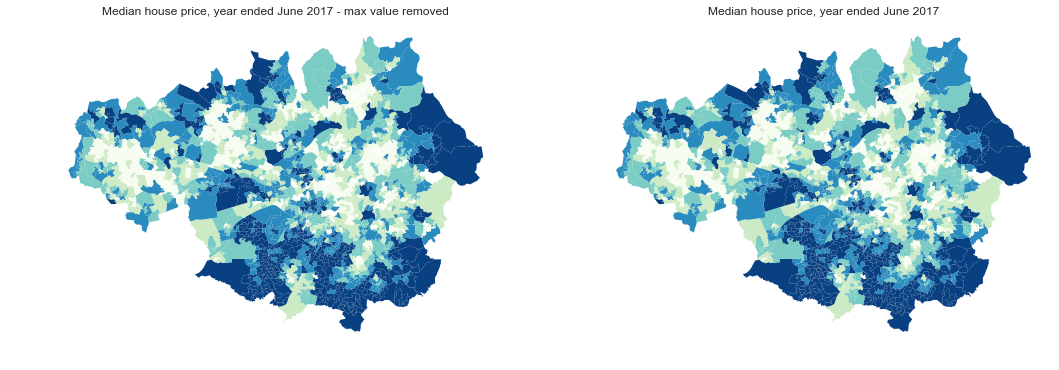

In [289]:
#  Replot houseprice data
#  Set up figure
f, ax = plt.subplots(1,2, figsize=(18, 6));
ax = ax.flatten();

#  Call subplots
df.plot(column = 'Year ending Jun 2017',\
                                cmap = 'GnBu',scheme='quantiles',ax=ax[0]);
data.plot(column = 'Year ending Jun 2017',\
                                cmap = 'GnBu',scheme='quantiles',ax=ax[1]);
#  Subplot titles
ax[0].title.set_text('Median house price, year ended June 2017 - max value removed')
ax[1].title.set_text('Median house price, year ended June 2017')

#  Square grid
#lims = plt.axis('equal');

#  Remove grid lines
ax[0].set_axis_off();
ax[1].set_axis_off();

plt.figure();

In [323]:
#  Descriptive statistics without house price outlier
df.describe().loc[['mean', 'std'], ['Year ending Jun 2017']]

,Year ending Jun 2017
mean,160258.050725
std,83801.537557


In [325]:
#Descriptive statistics with house price outlier
data.describe().loc[['mean', 'std'], ['Year ending Jun 2017']]

,Year ending Jun 2017
mean,160825.185275
std,86898.889895


#  3.0  Analysis

Analysis was conducted using Python (v.3), operating through a Jupyter Notebook.  Refer to the opening section of the code below for a list of packages and modules imported.  

For the prediction of house prices and analysis of the relationship between house prices and the variables in the analysis, an Ordinary Least Squares regression was performed.  Correlation was assessed using Pearson’s coefficient and a range of visualisations employed to understand the data including `heatmap` and `pairplot` from the `seaborn` package.

## 3.1  Correlations

All variables show a degree of correlation with house price (Pearson's coefficient >0.1) with the exception of greenspace and nitrogen dioxide where correlation is small, but still in a direction consistent with the hypotheses.

* An _increase_ in crime decile, correlates with an _increase_ in house price
* An _increase_ in distance to gambling and fast food outlets, correlates with an _increase_ in houseprice, although this is smaller for fast food, than for gambling.
* A _decrease_ in particulates and nitrogen dioxide, correlates with an _increase_ in house price
* An _increase_ in green space correlates with an _increase_ in house price

The dependent variable (_Year to Jun 2017_) was not normally distributed and so the natural log of this was used within the regression (*log_price*).  One outlier was removed for the regression modelling, a single LSOA with a median houseprice of in excess of £1.1m.  Removing just this outlier reduced the variance in house price for the whole dataset from £86,898 to £83,800.  The area in question is a wealthy suburb of Manchester within the Trafford borough bordering the "footballer belt" of Cheshire (LSOA E1006134).  Its full record is extracted and transposed for easier viewing in the code section.

In [349]:
#  Set up variable for log of the house price
df['log_price']= np.log(df['Year ending Jun 2017'])

#  Set up a list of variables
variables = list(df)

In [351]:
list(df)

['crime_d',
 'geometry',
 'Local authority name',
 'Year ending Jun 2017',
 'gamble',
 'fastfood',
 'particulates',
 'no2',
 'greenspace',
 'PT',
 'log_price']

In [340]:
# Create the correlation matrix
# This command calls a crosstabulation of Pearson's coefficient for all continous variables.
df.corr()

,crime_d,Year ending Jun 2017,gamble,fastfood,particulates,no2,greenspace,log_price
crime_d,1.000000,0.440333,0.402764,0.337927,-0.235096,-0.403282,-0.023266,0.496962
Year ending Jun 2017,0.440333,1.000000,0.218410,0.099719,-0.145620,-0.045285,0.038389,0.941256
gamble,0.402764,0.218410,1.000000,0.584165,-0.405112,-0.496531,0.011671,0.245673
fastfood,0.337927,0.099719,0.584165,1.000000,-0.324182,-0.474546,0.015466,0.144604
particulates,-0.235096,-0.145620,-0.405112,-0.324182,1.000000,0.701372,0.065894,-0.130747
no2,-0.403282,-0.045285,-0.496531,-0.474546,0.701372,1.000000,0.025893,-0.031432
greenspace,-0.023266,0.038389,0.011671,0.015466,0.065894,0.025893,1.000000,0.035132
log_price,0.496962,0.941256,0.245673,0.144604,-0.130747,-0.031432,0.035132,1.000000


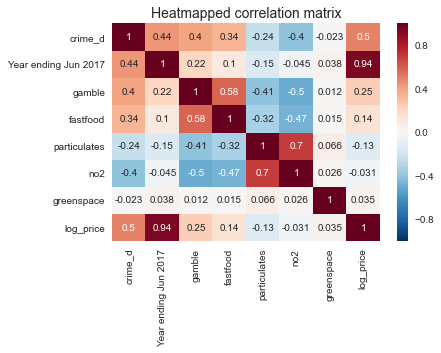

In [611]:
# Visualise the correlation matrix for continuous variables
sns.heatmap(df.corr(), annot=True);
plt.title('Heatmapped correlation matrix', fontsize = 14);
plt.show();

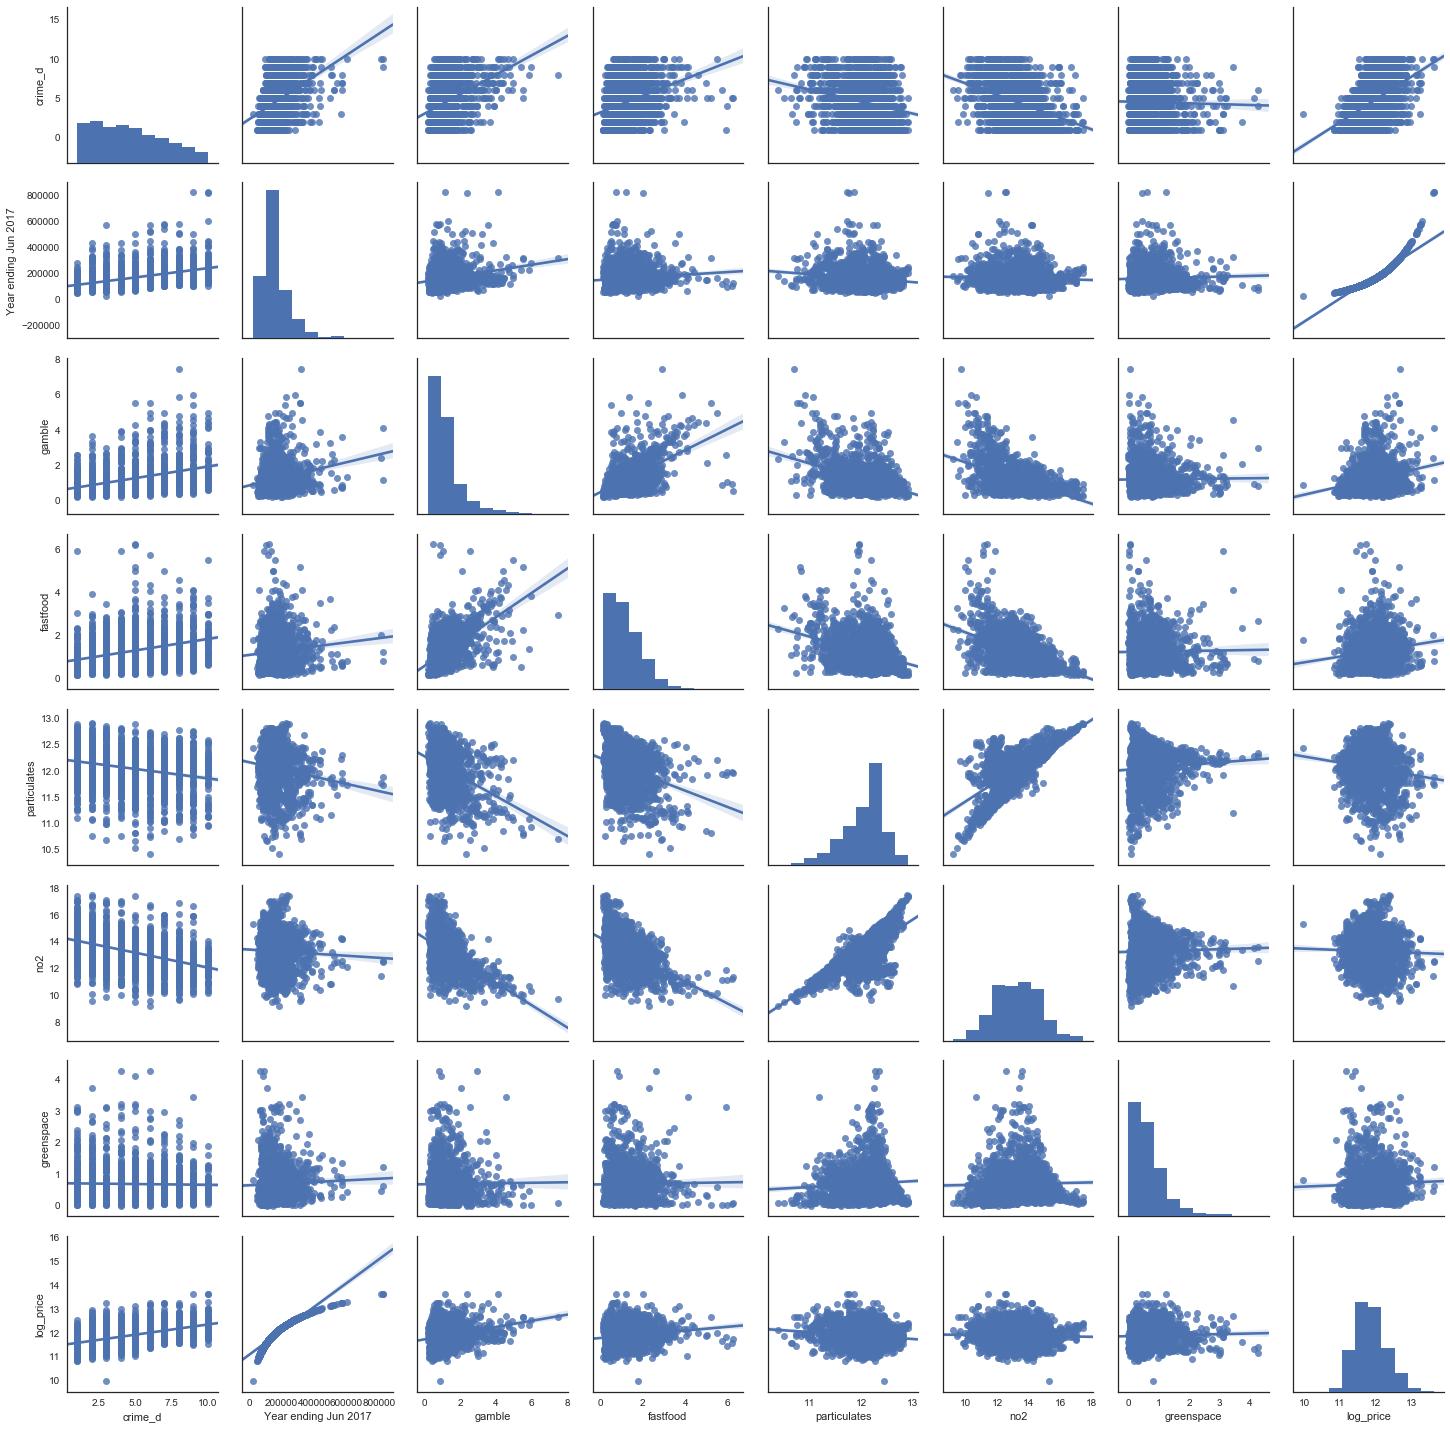

In [618]:
#  Seaborn pairs plot to illustrate pairwise correlation of continuous variables
sns.pairplot(df, kind='reg');

## 3.2  Ordinary Least Squares Regression Model
Three models were specified and the best fit selected using an $R^2$ measure.

* m1 includes all variables in the dataset
* m2 removes _fastfood_ as this was not statistically significant in the results for m1
* m3 removes no2 as this had a low correlation with house price, and is likely to be multicolinear with particulates
*  the best (highest) $R^2$ value is selected as the best model
*  density plot shows the fitted values compared with actual values.

### 3.2.1  Categorical variables
The variable _PT_ was categorised into two dummy variables (Moderate and Poor) with Good acting as the reference.  Python is able to automatically deal with categorical data and create dummy variables for use in a regression analysis.  Dummy variables are retrieved using the `get_dummies()` command.

In [606]:
df_dummies = pd.get_dummies(df['PT'])
df_dummies.head()

,Good,Moderate,Poor
LSOA code,,,
E01004766,1,0,0
E01004767,1,0,0
E01004768,0,1,0
E01004769,0,1,0
E01004770,0,1,0


###  3.2.2 Model 1

Model 1 includes all variables in the dataset.  The summary shows _fastfood_ to be statistically insignificant and so this is exclided from model 2.

Model 1 explains 33.6% of the variance.

In [619]:
# Basic model specification
model = 'log_price ~ gamble + fastfood + crime_d + greenspace + particulates + no2 + PT'

# Model 1 is a linear regression of house price, using the package statmodels
m1 = sm.ols(model, df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     104.2
Date:                Thu, 26 Apr 2018   Prob (F-statistic):          1.36e-140
Time:                        16:00:43   Log-Likelihood:                -670.72
No. Observations:                1656   AIC:                             1359.
Df Residuals:                    1647   BIC:                             1408.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.9758      0.323     40.169      0.000      12.342      13.609
PT[T.Moderate]     0.0460      0.019      2.394      0.017       0.008       0.084
PT[T.Poor]         0.0767      0.056      1.379      0.168      -0.032       0.186
gamble             0.0652      0.014      4.573      0.000       0.037       0.093
fastfood          -0.0058      0.014     -0.410      0.682      -0.034       0.022
crime_d            0.0956      0.004     24.253      0.000       0.088       0.103
greenspace         0.0377      0.016      2.366      0.018       0.006       0.069
particulates      -0.2880      0.032     -9.019      0.000      -0.351      -0.225
no2                0.1373      0.010     13.878      0.000       0.118       0.157
==============================================================================
Omnibus:                       94.852   Durbin-Watson:                   1.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.626
Skew:                           0.510   Prob(JB):                     4.31e-29
Kurtosis:                       3.923   Cond. No.                         677.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2.2  Model 2

Model 2 does not include _fastfood_.  Model 2 explains 33.6% of the variance.

In [620]:
# Basic model specification, removing fast food as not statistically significant in m1
model = 'log_price ~ gamble + crime_d + greenspace + particulates + no2  + PT'

#  Fit model, call summary of model results
m2 = sm.ols(model, df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     119.1
Date:                Thu, 26 Apr 2018   Prob (F-statistic):          1.30e-141
Time:                        16:01:01   Log-Likelihood:                -670.80
No. Observations:                1656   AIC:                             1358.
Df Residuals:                    1648   BIC:                             1401.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.9689      0.323     40.213      0.000      12.336      13.601
PT[T.Moderate]     0.0445      0.019      2.360      0.018       0.008       0.081
PT[T.Poor]         0.0739      0.055      1.339      0.181      -0.034       0.182
gamble             0.0629      0.013      4.798      0.000       0.037       0.089
crime_d            0.0955      0.004     24.271      0.000       0.088       0.103
greenspace         0.0377      0.016      2.366      0.018       0.006       0.069
particulates      -0.2887      0.032     -9.053      0.000      -0.351      -0.226
no2                0.1382      0.010     14.310      0.000       0.119       0.157
==============================================================================
Omnibus:                       96.208   Durbin-Watson:                   1.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.336
Skew:                           0.513   Prob(JB):                     1.11e-29
Kurtosis:                       3.937   Cond. No.                         674.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2.3 Model 3

In model 3, _no2_ was excluded to examine the impact of multicollinearity between this and the _particulates_ variable (Pearson’s coefficient of 0.7) (_no2_ removed rather than _particulates_ as it had a negligible correlation coefficient with the dependent variable).

This does not increase the amount of variance explained.  Model 3 explains 25.3% of variance.  Model 2 is selected as the model to be used.

In [390]:
# Basic model specification, removing no2 as multicolinear with particulates
model = 'log_price ~ gamble + crime_d + greenspace + particulates + PT'

m3 = sm.ols(model, df).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     93.27
Date:                Fri, 20 Apr 2018   Prob (F-statistic):          5.22e-101
Time:                        11:36:07   Log-Likelihood:                -767.78
No. Observations:                1656   AIC:                             1550.
Df Residuals:                    1649   BIC:                             1587.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.4473      0.323     35.469      0.000      10.814      12.080
PT[T.Moderate]     0.0403      0.020      2.016      0.044       0.001       0.080
PT[T.Poor]         0.0370      0.058      0.633      0.527      -0.078       0.152
gamble             0.0226      0.014      1.663      0.096      -0.004       0.049
crime_d            0.0810      0.004     20.103      0.000       0.073       0.089
greenspace         0.0332      0.017      1.967      0.049    9.46e-05       0.066
particulates      -0.0003      0.026     -0.013      0.990      -0.052       0.051
==============================================================================
Omnibus:                       97.837   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.822
Skew:                           0.593   Prob(JB):                     4.29e-26
Kurtosis:                       3.537   Cond. No.                         445.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [391]:
pd.Series({'M1': m1.rsquared,\
           'M2': m2.rsquared,\
           'M3': m3.rsquared})

M1    0.335957
M2    0.335889
M3    0.253373
dtype: float64

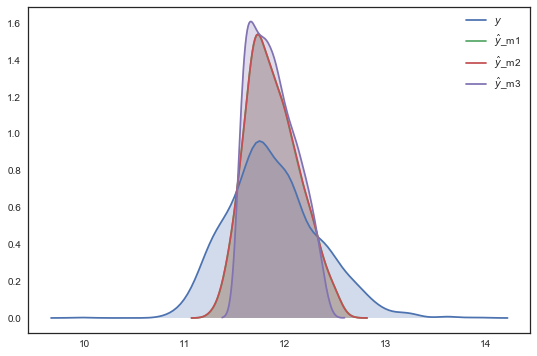

In [612]:
#  Plot the fitted values and the actual values to compare the model with the actual data.
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(data['log_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$_m1')
sns.kdeplot(m2.fittedvalues, shade=True, ax=ax, label='$\hat{y}$_m2')
sns.kdeplot(m3.fittedvalues, shade=True, ax=ax, label='$\hat{y}$_m3')
plt.show()

### 3.2.4  Cross validating model 2

Parameters for model 2 have been derived from the whole range of the dataset, however, when fitting a model to the whole of the data, there is a risk that we are overfitting, and that the parameters have little value for prediction.  This can be checked by fitting and cross validating a model, reserving some of the data from the fitting process, to test whether or not the model performs as well on unseen cases.

After model selection, the dataset was shuffled to remove structural patterns that might impact outcomes such as all LSOAs being ordered in Local Authority groups.  It was then split at a 70:30 ratio into training and testing datasets.  Model 2 was then trained on 70% of the data, and cross validated using a prediction for the remaining 30%.

In the training data set (a 70%) m2 explained 32.6% of variance, but this increased to 35.4% of the variance for the cross validation testing set.

Considering the mean squared error across all models tested so far, we see that the lowest value (0.128)is for the M2_train model - i.e. this model has the best fit to the underlying data.  The mean squared error for the prediciton is higher at 0.140.

There is not much difference int the $R^2$ or mean squared error values between the full dataset results for model 2 and the training data results, demonstrating that the M2 model is regularised.

In [364]:
#  Randomise data to ensure no structural features impact test/train split
dfs = shuffle(df)

# List of independent variables to be included.  Note that fast food has been removed.
ind = ['gamble','crime_d','greenspace','particulates','no2','PT']

# Split the data into 70% training, 30% testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(dfs,\
                                                                    dfs['log_price'],\
                                                                    test_size=0.3)                                              

In [383]:
#  Specify model 2 as identified above
model = 'log_price ~ gamble + crime_d + greenspace + particulates + no2  + PT'

#  Train the model on the dataset
#  Add log_price back into the x_train dataset using .assign()
m2_tr = sm.ols(model, x_train.assign(log_price=y_train)).fit()

In [631]:
# Build a series of mean squared error values
mse = pd.Series({'M1': metrics.mean_squared_error(df['log_price'],m1.fittedvalues),\
                 'M3': metrics.mean_squared_error(df['log_price'],m3.fittedvalues),\
                 'Full Dataset M2': metrics.mean_squared_error(df['log_price'],m2.fittedvalues), \
                 'Train Set M2':metrics.mean_squared_error(x_train.assign(log_price=y_train)['log_price']\
                                                           ,m2_tr.fittedvalues)},\
                   name = 'MSE')

In [632]:
#  Build a series of R2 values
R2 = pd.Series({'M1': m1.rsquared,\
                'M3':m3.rsquared,\
                'Full Dataset M2': m2.rsquared,\
                'Train Set M2': m2_tr.rsquared}, \
                 name='R2')

In [633]:
#  Display parameters, R2 and MSE as a dataframe
pd.DataFrame({'M1': m1.params,\
              'M3':m3.params,\
              'Full Dataset M2': m2.params,\
              'Train Set M2': m2_tr.params})\
        .append(R2).append(mse)

,Full Dataset M2,M1,M3,Train Set M2
Intercept,12.968921,12.975808,11.447309,13.029818
PT[T.Moderate],0.044504,0.046001,0.040301,0.045874
PT[T.Poor],0.073884,0.076704,0.036966,0.090277
crime_d,0.095482,0.095567,0.081014,0.092977
fastfood,NaN,-0.005833,NaN,NaN
gamble,0.062902,0.065197,0.022575,0.059009
greenspace,0.037661,0.037668,0.033177,0.034639
no2,0.138190,0.137311,NaN,0.130541
particulates,-0.288695,-0.288032,-0.000329,-0.283953
R2,0.335889,0.335957,0.253373,0.326269


In [386]:
#  Predict values for the testing dataset as cross validation.
#  Compare R2 for model 2.
test_pred = m2_tr.predict(x_test)

pd.Series({'0-Full Dataset': m2.rsquared,
           '1-Train Set': m2_tr.rsquared,
           '2-Test Set': metrics.r2_score(y_test,
                                        test_pred)})

pd.DataFrame({'M1': m1.params,\
              'M3':m3.params,\
              'Full Dataset M2': m2.params,\
              'Train Set M2': m2_tr.params})\
        .append(R2).append(mse)

0-Full Dataset    0.336974
1-Train Set       0.326269
2-Test Set        0.353985
dtype: float64

In [655]:
mser2 = pd.DataFrame()

In [657]:
# Build a series of mean squared error values and r2 values
mse = pd.Series({'M1': metrics.mean_squared_error(df['log_price'],m1.fittedvalues),\
                 'M3': metrics.mean_squared_error(df['log_price'],m3.fittedvalues),\
                 'Full Dataset M2': metrics.mean_squared_error(df['log_price'],m2.fittedvalues), \
                 'Train Set M2':metrics.mean_squared_error(x_train.assign(log_price=y_train)['log_price']\
                                                           ,m2_tr.fittedvalues),\
                 'Test M2': metrics.mean_squared_error(y_test,test_pred)},\
                   name = 'MSE')
R2 = pd.Series({'M1': m1.rsquared,\
                'M3':m3.rsquared,\
                'Full Dataset M2': m2.rsquared,\
                'Train Set M2': m2_tr.rsquared,\
                'Test M2': metrics.r2_score(y_test,test_pred)}, \
                 name='R2')     

In [659]:
# Display dataframe of fit measures.
mser2.append(mse).append(R2)

,Full Dataset M2,M1,M3,Test M2,Train Set M2
MSE,0.131634,0.131621,0.147990,0.140251,0.128068
R2,0.335889,0.335957,0.253373,0.353985,0.326269


Plotting the predicted and actual values as a density plot shows that model 2 predicts a taller, narrower distribution than is the case.  It will tend to predict more houses at higher prices than are seen in the data, and the prediction distribution has much shorter tails than the true data.

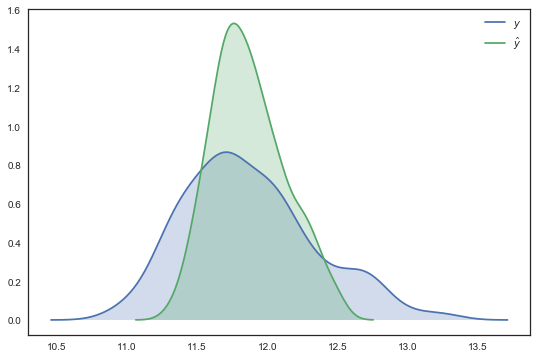

In [387]:
#  Plot the predicted values and the actual values to compare the model with the actual data.
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(y_test, shade=True, ax=ax, label='$y$')
sns.kdeplot(test_pred, shade=True, ax=ax, label='$\hat{y}$')
plt.show()

###  3.2.5  Discussion of OLS Regression result

Model 2 takes the form:

$$
\log(P) = 13.0 + 0.05PT(Moderate) + 0.09PT(Poor) + 0.09(crime decile) + 0.06(gamble) + 0.03(greenspace) +  0.13(no2)  - 0.28(particulates)  + \epsilon
$$

This throws up some interesting results.  For the *PT* variable, the reference is *good*, but in fact having either a _moderate_ or _poor_ rating in this variable has a positive contribution to the property price in the area, with _poor_ contributing more than _moderate_ (0.09 vs 0.05).

An increase in greenspace increases house price – it may be that these areas of poorer public transport are leafier suburbs.  More difficult to get to work, but potentially more pleasant places to live, leading to an increased property price.

In this model, nitrogen dioxide emissions increase house prices, but particulate levels decrease them.  This seems to be  contradictory as both are measures of poor air quality which it is expected would reduce the value of property however when the geographic plot is considered it is clear that nitrogen dioxide levels are correlated with the city centre -  a desirable place to live with higher property prices.

Particulates are similarly correlated with the city centre but are also measured as higher in the Wigan local authority (in the North East of Manchester on the plot).  Wigan is a poorer area with lower house prices so it may be that particulates are in fact correlated with another measure (say of deprivation) which negatively impacts prices.

When the crime decile increases, the area is subject to less crime, and e see an increasing house price.

Finally, having to travel further to the nearest gambling outlet, increases the house price.  Higher incidences of gambling outlets are found in areas of higher socio-economic deprivation – i.e. less desirable residential areas.

##  3.3 Classifying the data, an exploration of clustering

### 3.3.1  Visualising variables
Going back to the original full dataset, `data` (remembering that `df` used above has an outlier removed for the purposes of the linear regression) we can explore whether or not there are inherent patterns which lead to clusters of similar LSOAs for these variables, and whether or not we can use a clustering approach to predict which local authority an LSOA belongs to.

Using a groupby function, the mean of the house price data is plotted against each local authority, the data can also be visualised as boxplots, grouped by local authority.

The mean of the median house price data is plotted as a map to show that there are some local authorities where house prices are in general higher.

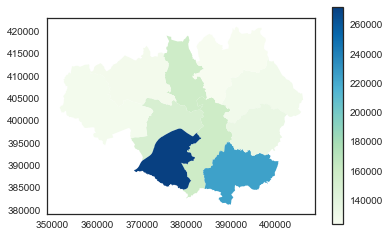

In [538]:
#  Plot the mean property price, by local authority using the local authority boundary data.
GM_LA.join(df.groupby('Local authority name').mean(), on ='Local authority name')\
     .plot(column='Year ending Jun 2017',\
           cmap='GnBu',\
           legend=True);

In [394]:
data.groupby('Local authority name').describe()

Year ending Jun 2017                                \
                                    count           mean            std   
Local authority name                                                      
Bolton                              177.0  127031.644068   56663.456850   
Bury                                120.0  158807.066667   59056.277069   
Manchester                          279.0  159241.587814   75088.411604   
Oldham                              138.0  128072.804348   58394.168449   
Rochdale                            131.0  123357.755725   51072.770500   
Salford                             147.0  150482.448980   59991.240938   
Stockport                           189.0  224739.835979   90845.782342   
Tameside                            139.0  134312.863309   42460.257136   
Trafford                            137.0  278219.832117  147685.459751   
Wigan                               200.0  126506.065000   39776.443468   

                                                                         \
                          min       25%       50%        75%        max   
Local authority name                                                      
Bolton                56250.0   85250.0  113000.0  152500.00   415000.0   
Bury                  65000.0  117000.0  147225.0  189043.75   370000.0   
Manchester            21500.0  113000.0  137000.0  189125.00   570000.0   
Oldham                50000.0   85000.0  119247.5  152750.00   320000.0   
Rochdale              57500.0   85875.0  112250.0  144875.00   346000.0   
Salford               65000.0  110625.0  135000.0  170997.50   450000.0   
Stockport             75750.0  151500.0  218750.0  270000.00   539950.0   
Tameside              75500.0  106575.0  124000.0  150624.00   374950.0   
Trafford              94000.0  190000.0  244000.0  308500.00  1100000.0   
Wigan                 54000.0   97250.0  122625.0  152000.00   258000.0   

                     crime_d              ...            no2             \
                       count      mean    ...            75%        max   
Local authority name                      ...                             
Bolton                 177.0  4.728814    ...      13.462890  14.548274   
Bury                   120.0  5.483333    ...      13.217614  14.252429   
Manchester             279.0  2.555556    ...      15.358539  17.421849   
Oldham                 138.0  4.159420    ...      14.113868  14.742441   
Rochdale               131.0  3.465649    ...      12.615326  14.558422   
Salford                147.0  4.564626    ...      15.129575  17.451187   
Stockport              189.0  4.978836    ...      14.242674  14.849885   
Tameside               139.0  4.071942    ...      14.290457  14.960017   
Trafford               137.0  6.978102    ...      13.952677  16.045551   
Wigan                  200.0  5.510000    ...      12.096917  13.080365   

                     particulates                                             \
                            count       mean       std        min        25%   
Local authority name                                                           
Bolton                      177.0  11.978939  0.337930  10.932943  11.779035   
Bury                        120.0  11.877685  0.407215  10.770212  11.661484   
Manchester                  279.0  12.348014  0.213349  11.576358  12.242918   
Oldham                      138.0  11.858259  0.409672  10.699004  11.571049   
Rochdale                    131.0  11.628033  0.456139  10.397870  11.297001   
Salford                     147.0  12.417047  0.216368  11.958782  12.267082   
Stockport                   189.0  11.856472  0.361126  11.067176  11.555678   
Tameside                    139.0  11.902953  0.375273  11.125822  11.626199   
Trafford                    137.0  12.132802  0.249309  11.723528  11.949756   
Wigan                       200.0  12.193556  0.203875  11.730401  12.026508   

                                                    

Boxplots of the variables grouped by local authority show that most variables have overlapping distributions but that there are some clear differences between authorities - for example in the nitrogen dioxide variable, where Manchester and Wigan have distinct distributions. 

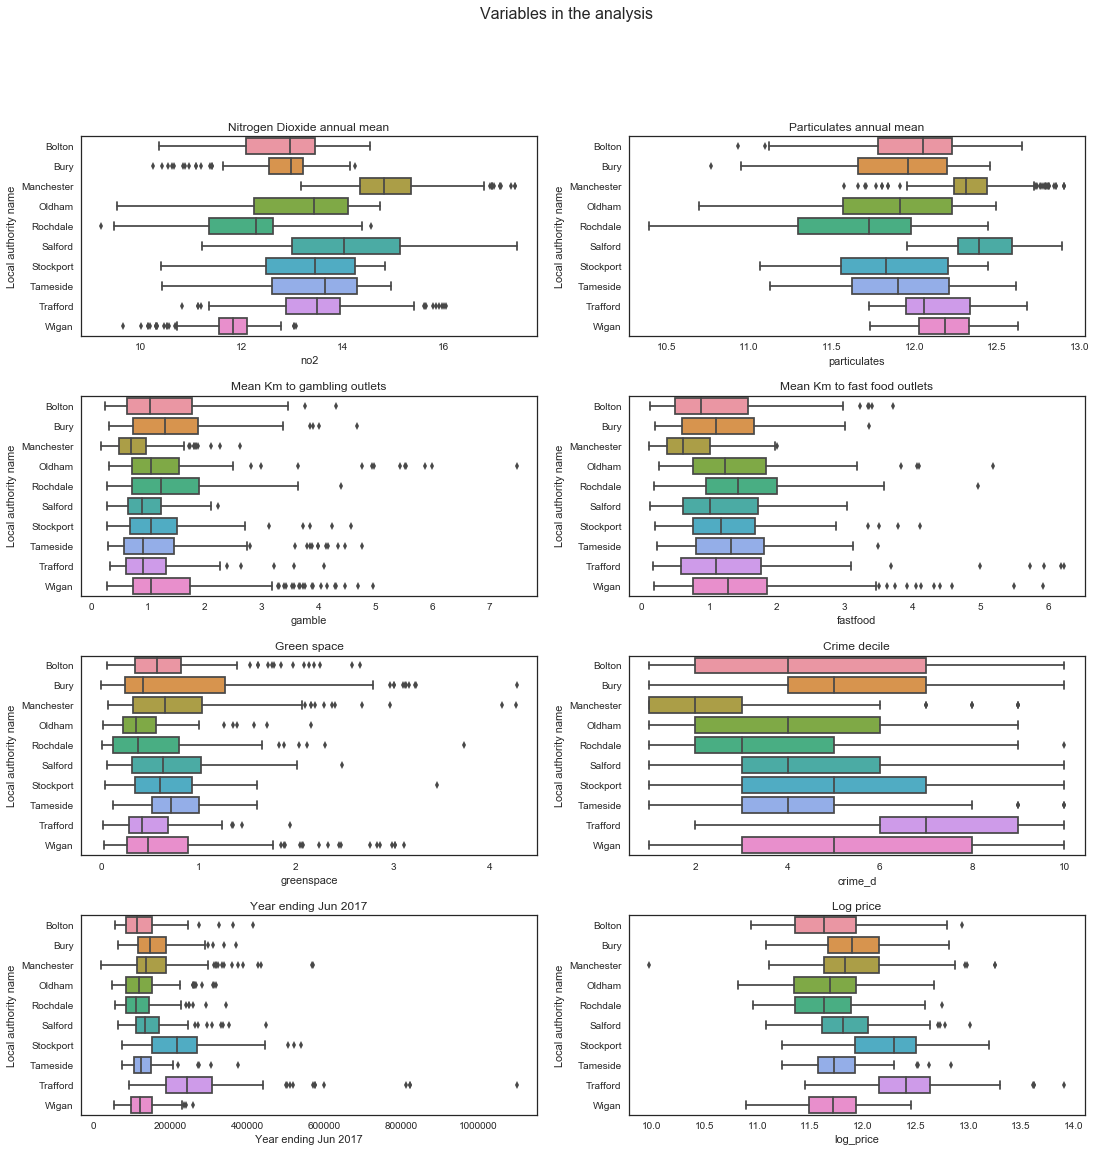

In [494]:
f, ax = plt.subplots(4,2, figsize=(18, 18));
ax = ax.flatten();

sns.boxplot(y='Local authority name', x='no2', data=data, ax = ax[0]);
sns.boxplot(y='Local authority name', x='particulates', data=data, ax = ax[1]);
sns.boxplot(y='Local authority name', x='gamble', data=data, ax = ax[2]);
sns.boxplot(y='Local authority name', x='fastfood', data=data, ax = ax[3]);
sns.boxplot(y='Local authority name', x='greenspace', data=data, ax = ax[4]);
sns.boxplot(y='Local authority name', x='crime_d', data=data, ax = ax[5]);
sns.boxplot(y='Local authority name', x='Year ending Jun 2017', data=data, ax = ax[6]);
sns.boxplot(y='Local authority name', x='log_price', data=data, ax = ax[7]);

# Specify subplot titles
ax[0].title.set_text('Nitrogen Dioxide annual mean');
ax[1].title.set_text('Particulates annual mean');
ax[2].title.set_text('Mean Km to gambling outlets');
ax[3].title.set_text('Mean Km to fast food outlets');
ax[4].title.set_text('Green space');
ax[5].title.set_text('Crime decile');
ax[6].title.set_text('Year ending Jun 2017');
ax[7].title.set_text('Log price');

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.3)
#sharey = True
plt.suptitle('Variables in the analysis', fontsize = 16)
plt.show()

A swarm and strip plot of the excluded PT variable does not show any clear grouping of house price data by the availability of public transport in the area.

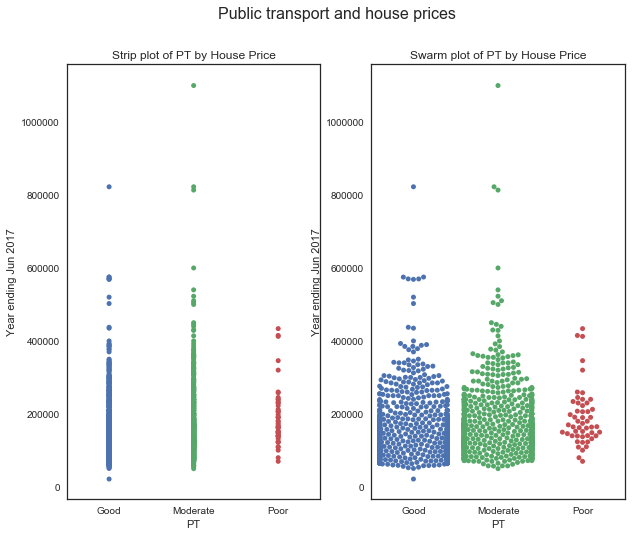

In [515]:
f, ax = plt.subplots(1,2, figsize = (10,8));
ax = ax.flatten();

sns.swarmplot(x = 'PT', y = 'Year ending Jun 2017',data = data, ax = ax[1]);
sns.stripplot(x = 'PT', y = 'Year ending Jun 2017',data = data, ax = ax[0]);

ax[0].title.set_text('Strip plot of PT by House Price');
ax[1].title.set_text('Swarm plot of PT by House Price');

plt.suptitle('Public transport and house prices', fontsize = 16)
plt.show()


### 3.3.2  k-means and categorical variables
The k-means clustering algorithm is not suited to categorical, or mixed continuous and categorical data (Khan 2016). There are alternative algorithms such as k-modes , or the categorical variable can be restructured into dummy variables (Huang 1998) . For simplicity, the categorical variable _PT_ was excluded from the clustering analysis.

### 3.3.3 Standardising variables
In order for the clustering algorithms to proceed and produce meaningful results, there must be no missing data and the variables must be standardised.  Missing data was addressed earlier in the analysis, standardisation is carryied out through the proprocessing module of scikit-learn.  All variables are standardised to give a mean of zero, and a standard deviation of 1.  These transformed values are then used for the cluster analysis.(Gan et al 2007).

In [528]:
var_cl = ['Year ending Jun 2017','greenspace','fastfood','gamble','particulates','no2','crime_d']
#  Standardising the variables sets the mean to zero, and the standard deviation to 1.
d = data[var_cl]
d_sd = pd.DataFrame(preprocessing.scale(d),\
                    index = d.index,\
                    columns=d.columns)

In [530]:
# CHeck that all variables have a mean of 0 and an SD of 1
d_sd.describe().loc[['mean', 'std'], :]

,Year ending Jun 2017,greenspace,fastfood,gamble,particulates,no2,crime_d
mean,1.040876e-16,-2.552776e-17,-3.026480e-16,-9.226174e-17,-1.355584e-15,1.696490e-16,-1.480610e-15
std,1.000302e+00,1.000302e+00,1.000302e+00,1.000302e+00,1.000302e+00,1.000302e+00,1.000302e+00


###  3.3.4  Using k-means to determine clusters within the data
* Try 10 clusters - do the clusters match the local authorities?
* Use loop and scree plot to determine the right number of clusters.
* Run clusters and obtain cluster labels
* Reduce dimensionality using principle components analysis, then re-run k-means clustering
* Compare dispersion of cases about centroids to determine the optimum clustering.

There are 10 local authorities within Greater Manchester.  Specifying `n_clusters = 10` indicates whether or not the data is naturally grouped into these administrative boundaries.  Using a cross tabulation it is clear that the k-means algorithm is not a suitable method for predicting the local authority.

In [551]:
#  Set up a cluster model
km10 = cluster.KMeans(n_clusters=10)

#  Initialise a random number
#  Perform kmeans clustering
np.random.seed(1234)
k10 = km10.fit(d_sd)

#  Display labels
d_sd.groupby(k10.labels_)\
        .size()

#  Add k10 labels as a field within the dataset
data['k10_label']=k10.labels_

0     71
1    112
2    196
3    229
4    111
5    192
6    211
7     80
8    283
9    172
dtype: int64

In [556]:
pd.crosstab(data['k10_label'],data['Local authority name'])

Local authority name,Bolton,Bury,Manchester,Oldham,Rochdale,Salford,Stockport,Tameside,Trafford,Wigan
k10_label,,,,,,,,,,
0,8,3,0,11,9,0,5,9,6,20
1,15,23,38,2,9,5,2,1,1,16
2,15,10,15,21,22,22,29,33,7,22
3,30,21,1,34,47,1,29,24,1,41
4,17,27,0,11,28,0,19,9,0,0
5,29,15,2,7,8,20,8,8,21,74
6,6,8,39,10,4,33,39,14,57,1
7,2,1,5,0,0,2,30,1,39,0
8,55,12,65,42,4,20,23,36,0,26


Using a loop, the number of clusters specified to the kmeans algorithm is altered, allowing a scree plot to be generated. In a scree plot, we look for an elbow in the line, where there is a clear change in gradient.  This plot is a little unclear - there could be accelerations at k = 5 and k = 2.  For this analysis, `n_clusters` is set to 5.

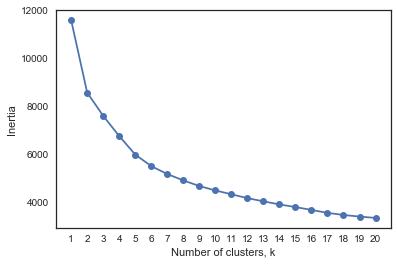

In [536]:
#  Make a scree plot of clusters
ks = range(1, 21)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cluster.KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(d_sd)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [540]:
#  Set up a cluster model
km5 = cluster.KMeans(n_clusters=5)

#  Initialise a random number
#  Perform kmeans clustering
np.random.seed(1234)
k5 = km5.fit(d_sd)

#  Add cluster labels to the data 
data['k5_label']=k5.labels_

#  Display labels
d_sd.groupby(k5.labels_)\
        .size()

0    495
1    515
2    160
3    346
4    141
dtype: int64

Dimensionality of the data is reduced using principle components analysis, and a comparison made between clusters derived using k-means on both reduced, and original data using the Calinski-Harabasz score from the metrics module of scikit-learn.  A higher score represents a better clustering solution and in this analysis, the best solution is achieved using 5 clusters and without first reducing dimensionality (Galarynk 2017).

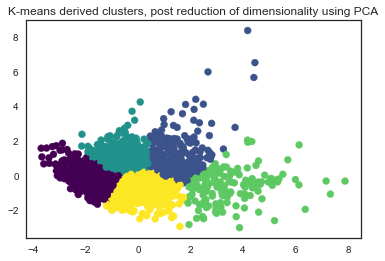

In [678]:
#  Reduce dimensionality to 2 dimensions
pca = PCA(n_components=2).fit_transform(d_sd)

# k=5 kmeans clustering of reduced dimensionality data
k_pca_5 = cluster.KMeans(n_clusters=5).fit(pca)

#  Plot the pca version of kmeans as it only has two dimensions.
#  Note that the axes are meaningless as they are a transformation of a combination of variables
plt.scatter(pca[:, 0], pca[:, 1], 
            c=k_pca_5.labels_, cmap='viridis',
            alpha=1);
plt.title('K-means derived clusters, post reduction of dimensionality using PCA')
plt.show()

In [560]:
#  Assess dispersion of the two k5 models (with and without pca)
chs_k5 = metrics.calinski_harabaz_score(d_sd, k5.labels_)
chs_k_pca_5 = metrics.calinski_harabaz_score(d_sd, k_pca_5.labels_)
chs_k10 = metrics.calinski_harabaz_score(d_sd, k10.labels_)

pd.Series({'chs_k5': chs_k5,
           'chs_k_pca_5': chs_k_pca_5,
           'chs_k10': chs_k10})

chs_k10        288.194669
chs_k5         385.497948
chs_k_pca_5    328.958807
dtype: float64

### 3.3.5 Visualising the final clustering solution

Using matplotlib to build several plots onto the same axes, the local authority boundaries can be overlaid onto the mapping of k5 clusters.

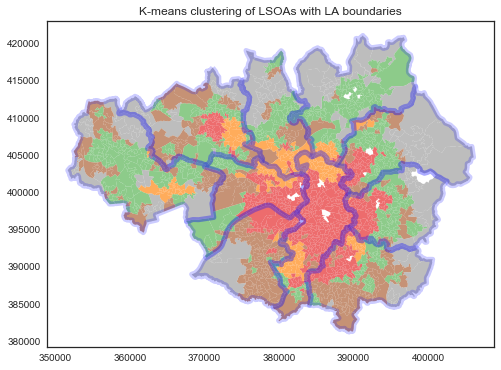

In [608]:
f,ax = plt.subplots(1,figsize=(8,6))
#  Plot the Cluster labels as a map
data.plot(column='k5_label',\
           cmap='Set1', alpha = 0.8, ax=ax);
GM_LA.plot(alpha=0.2, facecolor = 'w', edgecolor = 'b', linewidth = 5, ax=ax);
plt.title('K-means clustering of LSOAs with LA boundaries')
plt.show();

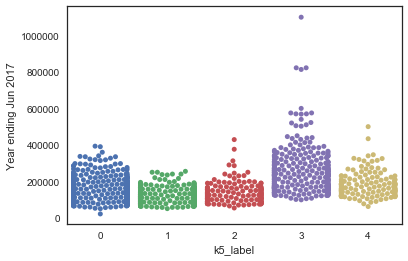

In [615]:
sns.swarmplot(x = 'k5_label', y = 'Year ending Jun 2017', data = data);
#sns.stripplot(x = 'PT', y = 'Year ending Jun 2017',data = data, ax = ax[0]);

### 3.3.6 Discussion of clusters

It is clear from the mapping of clusters that the LSOAs are clustered into groups which move progressively further from the city centre.  The large red central area on the plot corresponds with central Manchester, and the area appearing in the top left corner of the GM map, corresponds to Bolton centre - Bolton is a very distinct town within the Greater Manchester city region.

The clusters do not particuarly correspond with the local authority boundaries, as demonstrated by the cross tabulation although clearly there is a trend towards certain cluster labels (grey and green here) as local authorities are situated further from the centre of the city.

Using a groupby we can more clearly see the differences between clusters.

Cluster 3 has the highest mean houseprice, and typically is an area of lower reported crime, lower pollution and higher distance to gambling and fast food outlets.

CLuster 4 is similar to cluster 3, but has an even higher distance to gambling and fastfood outlets, but a lower house price and a lower level of greenspace.

The cheapest housing is found in cluster 1.  Cluster 0 has the easiest access to gambling and fastfood outlets, the worse pollution and the lowest green space, but house prices are higher than for clusters 1 and 2 indicating that perhaps there are other benefits to living in these areaa, causing the market price for housing to be higher.  It may be that the housing stock is bigger here, or it may be that these are close to desirable areas or particualrly well located for transport.

In [675]:
data.groupby('k5_label').median()

,crime_d,Year ending Jun 2017,gamble,fastfood,particulates,no2,greenspace,log_price,k10_label
k5_label,,,,,,,,,
0,3.0,132000.0,0.673699,0.640800,12.333606,14.683750,0.466239,11.790557,8
1,4.0,112000.0,0.897556,1.116744,11.937953,12.653616,0.474396,11.626254,3
2,3.0,125000.0,0.960502,0.938216,12.225199,13.789033,1.743032,11.736069,1
3,8.0,229250.0,1.336296,1.421299,11.984894,12.777475,0.624352,12.342563,5
4,7.0,164500.0,2.975135,2.591087,11.430186,11.303342,0.365948,12.010666,0


In [676]:
data.groupby('k5_label').mean()

,crime_d,Year ending Jun 2017,gamble,fastfood,particulates,no2,greenspace,log_price,k10_label
k5_label,,,,,,,,,
0,3.014141,148039.838384,0.737903,0.728949,12.379422,14.845222,0.530399,11.826674,7.656566
1,3.598058,116363.312621,0.983492,1.174519,11.909548,12.600545,0.513458,11.620435,3.778641
2,3.562500,135733.006250,1.040413,1.055825,12.200979,13.603276,1.894576,11.746036,2.206250
3,7.566474,248646.517341,1.388543,1.464128,11.952648,12.722092,0.681168,12.336947,5.367052
4,6.659574,181074.680851,3.176517,2.716613,11.510589,11.237217,0.525189,12.044184,2.035461


# 4.0  Limitations and future direction of modelling

The modelling undertaken here is subject to some immediate serious limitations.

There are no data for the type of residence sold - we have no control variables to account for effect of the number of bedrooms or type of property on the property price.  The types of properties in each area are unlikely to be evenly distributed, with more, smaller apartments in the city centre, and fewer, bigger houses in the suburbs.  The measure of public transport availability is somewhat crude, and there is no measure of the level of "desirability bias" which may apply to certain areas in the city for historic reasons.

A major driver of houseprices in areas with a large stock of housing suitable for families, is the availability of good schools, another variable which could be built in to improve the accuracy of the model.

House prices are also dependent on prices around them. If one LSOA becomes more desirable - for whatever reason, the neighbouring prices will also increase.  This spatial auto-correlation requires a more sophisticated modelling strategy.

An alternative approach to this problem would be to employ a random forest algorithm to both the classification and the regression.  This is a well used supervised machine learning technique that can be implemented through the `scikit-learn` package.

## 4.1  Where should I live?

Ultimately, where to purchase a home is dependent on a multitude of factors and these compete for priority.  

A tool could be developed which builds upon the results of this and further analysis allowing a user to input a level of preference for different lifestyle oriented fields, and then makes a recommendation for an area to start house hunting.  It might be more important to an asthma sufferer to have low pollution levels, than how many fast food outlets there are nearby, for example.

This type of preference already exists for housing type on many of the online estate agencies - for example you might specify flats with a minimum of 2 bedrooms - but these are dependent on knowing which __area__ you wish to search, and thus require knowledge of each local area prior to beginning a house hunt.  Building in these additional variables would potentially open up alternative areas for a person searching to buy a house and might therefore widen the market, reducing pressure on supply (and hence upward price pressure) in those areas which are well known for certain characteristics.

# 5.0  References

Anderson, J.R. and Crocker, T.D. (2016). Air Pollution and Residential Property Values: Urban Studies. [online]. Available from: http://journals.sagepub.com/doi/abs/10.1080/00420987120080391?journalCode=usja [Accessed April 24, 2018].

CDRC. (2015). CDRC 2015 English indices of deprivation Geodata Pack: Greater Manchester (E37000015) - CDRC Data. [online]. Available from: https://data.cdrc.ac.uk/dataset/cdrc-2015-english-indices-of-deprivation-geodata-pack-greater-manchester-e37000015 [Accessed April 24, 2018].

CDRC. (2017). Access to Health Assets and Hazards. [online]. Available from: https://data.cdrc.ac.uk/dataset/cdrc-2015-english-indices-of-deprivation-geodata-pack-greater-manchester-e37000015 [Accessed April 24, 2018].

Conway, D., Li, C.Q., Wolch, J., Kahle, C., Jarrett, M., (2010). A Spatial Autocorrelation Approach for Examining the Effects of Urban Greenspace on Residential Property Values.  J Real Estate Finan Econ (2010) 41:150–169 DOI 10.1007/s11146-008-9159-6  [Accessed April 30 2018]

Department for Transport. (2007). Travel time, destination and origin indicators to Employment centres by mode of travel, Lower Super Output Area (LSOA), England, from 2007 (acs0501). [online]. Available from: https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/357458/acs0501.xls [Accessed April 24, 2018].

English Housing Survey. (2017). English Housing Survey 2015 to 2016: headline report. GOV.UK. [online]. Available from: https://www.gov.uk/government/statistics/english-housing-survey-2015-to-2016-headline-report [Accessed April 30, 2018].

Frischtak, C. and Mandel, B.R. (2012). Crime, House Prices, and Inequality: The Effect of UPPs in Rio. [online]. Available from: https://papers.ssrn.com/abstract=1995795 [Accessed April 24, 2018].

Galarnyk, M. (2017). PCA using Python (scikit-learn). Towards Data Science. [online]. Available from: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 [Accessed April 24, 2018].

Gan, G., Ma, C. and Wu, J. (2007). Data Clustering: Theory, Algorithms, and Applications. SIAM.

Gibbons, S. and Machin, S. (2008). Valuing school quality, better transport, and lower crime: evidence from house prices. Oxford Review of Economic Policy, 24(1), pp.99–119.

Huang, Z. (1998). Extensions to the k-Means Algorithm for Clustering Large Data Sets with Categorical Values. Data Mining and Knowledge Discovery, p.22.

Khan, S. (2016). Why does K-means clustering perform poorly on categorical data? The weakness of the K-means method is that it is applicable only when the mean is defined, one needs to specify K in advance, and it is unable to handle noisy data and outliers. - Quora. [online]. Available from: https://www.quora.com/Why-does-K-means-clustering-perform-poorly-on-categorical-data-The-weakness-of-the-K-means-method-is-that-it-is-applicable-only-when-the-mean-is-defined-one-needs-to-specify-K-in-advance-and-it-is-unable-to-handle-noisy-data-and-outliers [Accessed April 24, 2018].

Manchester City Council. (2018). Councils in Greater Manchester | Councils in Greater Manchester | Manchester City Council. [online]. Available from: http://www.manchester.gov.uk/info/100004/the_council_and_democracy/66/councils_in_greater_manchester/1 [Accessed April 24, 2018].

Money Advice Service. (2018). Government schemes for first-time home buyers and existing homeowners. [online]. Available from: https://www.moneyadviceservice.org.uk/en/articles/help-to-buy-homebuy-and-other-housing-schemes [Accessed April 30, 2018].

ONS. (2018). Median price paid for administrative geographies - HPSSA Dataset 9 - Office for National Statistics. [online]. Available from: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianhousepricefornationalandsubnationalgeographiesquarterlyrollingyearhpssadataset09 [Accessed April 24, 2018].

Ortalo-Magne, F. and Rady, S. (1999). Boom in, bust out: Young households and the housing price cycle. European Economic Review, 43(4–6), pp.755–766.

Tse, R.Y.C. (2016). Estimating Neighbourhood Effects in House Prices: Towards a New Hedonic Model Approach: Urban Studies. [online]. Available from: http://journals.sagepub.com/doi/abs/10.1080/00420980220135545 [Accessed April 24, 2018].

UK Government. (2011). Census Merged Local Authority Districts (December 2011) Generalised Clipped Boundaries in Great Britain |. [online]. Available from: http://geoportal.statistics.gov.uk/datasets/census-merged-local-authority-districts-december-2011-generalised-clipped-boundaries-in-great-britain [Accessed April 24, 2018].

Wardle, H. et al. (2014). ‘Risky Places?’: Mapping Gambling Machine Density and Socio-Economic Deprivation. Journal of Gambling Studies, 30(1), pp.201–212. [online].  Available from: http://eprints.gla.ac.uk/73285/ [Accessed April 24, 2018].